In [1]:
# Core libraries
import random
import math
from math import factorial, exp
import numpy as np
from scipy.stats import binom, poisson
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
from itertools import combinations, permutations
from pathlib import Path

# Graph libraries
import rustworkx as rx
import networkx as nx
from rustworkx.visualization import mpl_draw

In [2]:
# Visualization settings


np.set_printoptions(precision=2, suppress=True)

NS_PURPLE = "#8e44ad"  # Node color
NS_GREEN = "#2ecc71"   # Edge color
NS_ORANGE = "#FF9800"  # Highlight color

plt.rcParams['figure.figsize'] = (3, 2)
plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.edgecolor": "0.3",
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

# File paths
ROOT = Path.cwd().parent
DATADIR = ROOT/"data"

In [3]:
# Utility functions

def pprint(G):
    """Pretty print basic graph statistics."""
    print(f"Graph has {G.num_nodes()} nodes and {G.num_edges()} edges")

def convert_rustworkx_to_networkx(graph):
    """Convert a rustworkx PyGraph or PyDiGraph to a networkx graph."""
    edge_list = [(
        graph[x[0]], graph[x[1]],
        {'weight': x[2]}) for x in graph.weighted_edge_list()]

    if isinstance(graph, rx.PyGraph):
        if graph.multigraph:
            return nx.MultiGraph(edge_list)
        else:
            return nx.Graph(edge_list)
    else:
        if graph.multigraph:
            return nx.MultiDiGraph(edge_list)
        else:
            return nx.DiGraph(edge_list)

ER = rx.undirected_gnp_random_graph

In [4]:
import os

def set_seed(seed: int | None = None) -> int:
    """Set all relevant random seeds and return the seed used."""
    if seed is None:
        # or use secrets, or something else
        seed = int.from_bytes(os.urandom(4), "big")

    # Python's built-in RNG
    random.seed(seed)

    # NumPy legacy global RNG
    np.random.seed(seed)

    return seed

# Chapter 4: Scale-Free Property

> **Network Science** by Albert-László Barabási  
> Companion Notebook using [rustworkx](https://www.rustworkx.org/)

---

This notebook provides Python implementations of the key concepts from Chapter 4 of the Network Science textbook. We use the `rustworkx` library for efficient graph operations.

## 4.2 Power Laws and Scale-Free Networks
Many network quantities (like degree and centrality) exhibit fat-tailed behavior consistent with a power-law, meaning there is no characteristic “typical” scale. As a result, large events aren’t anomalies—they’re a predictable consequence of the distribution’s *tail*

#### Discrete Formalism

$$
\{k∣k∈Z,k≥0\}
$$

$$
p_k = C k^{-\gamma}
$$



The constant $C$ is determined by the normalization condition

$$
C \sum_{k=1}^{\infty}k^{-\gamma} = 1
$$

In [54]:
gamma = 2

ks = [k for k in range(1, 1000)]

k_gamma = np.array([k**-gamma for k in ks]).sum()
C = 1./k_gamma

pks = C * np.array([k**-gamma for k in ks])

print(f"C = {C}")
print(f"sum of C * k^-gamma: {np.round(pks.sum(), 2)}")

C = 0.60829708710103
sum of C * k^-gamma: 1.0


The normalization constant $C$ can be expressed in closed form using the Riemann–zeta function.
Let $K=\max(ks)$. Define
$$
C_K = \frac{1}{\sum_{k=1}^{K} k^{-\gamma}}.
$$
As $K \to \infty$ (for $\gamma>1$),
$$
C_K \longrightarrow \frac{1}{\sum_{k=1}^{\infty} k^{-\gamma}}
= \frac{1}{\zeta(\gamma)}.
$$
Thus for $k \ge 1$ the discrete power-law (zeta) distribution has the form
$$
p_k = \frac{k^{-\gamma}}{\zeta(\gamma)}.
$$
Here $\zeta(\gamma)=\sum_{k=1}^{\infty} k^{-\gamma}$ is the Riemann–zeta function.
In SciPy, this can be computed as `scipy.special.zeta(gamma, 1)`.


In [66]:
def discrete_power_pmf(k, gamma=2):
    n = k**-gamma
    d = sp.zeta(gamma, 1)
    return n/d

a = C * 3**-gamma
b = discrete_power_pmf(3, gamma=2)
assert np.isclose(a, b, .01)

#### Continuum Formalism
:TODO

## 4.2 Hubs
The main difference between a random and a scale-free network comes in the tail of the degree distribution, representing the high-k region of $p_k$

In [68]:
discrete_power_pmf(5, gamma=2.1)

np.float64(0.021826199229132835)

In [70]:
poisson.pmf(5, 11)

np.float64(0.0224152134497488)

In [77]:
ks = np.array([i for i in range(1, 50)], dtype=float)
poission_pks = poisson.pmf(ks, mu=11)
power_pks = [discrete_power_pmf(k, gamma=2.1) for k in ks]

In [78]:
poission_pks = poisson.pmf(ks, mu=11)

In [79]:
poission_pks

array([0.  , 0.  , 0.  , 0.01, 0.02, 0.04, 0.06, 0.09, 0.11, 0.12, 0.12,
       0.11, 0.09, 0.07, 0.05, 0.04, 0.02, 0.01, 0.01, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ])

In [80]:
power_pks = [discrete_power_pmf(k, gamma=2.1) for k in ks]

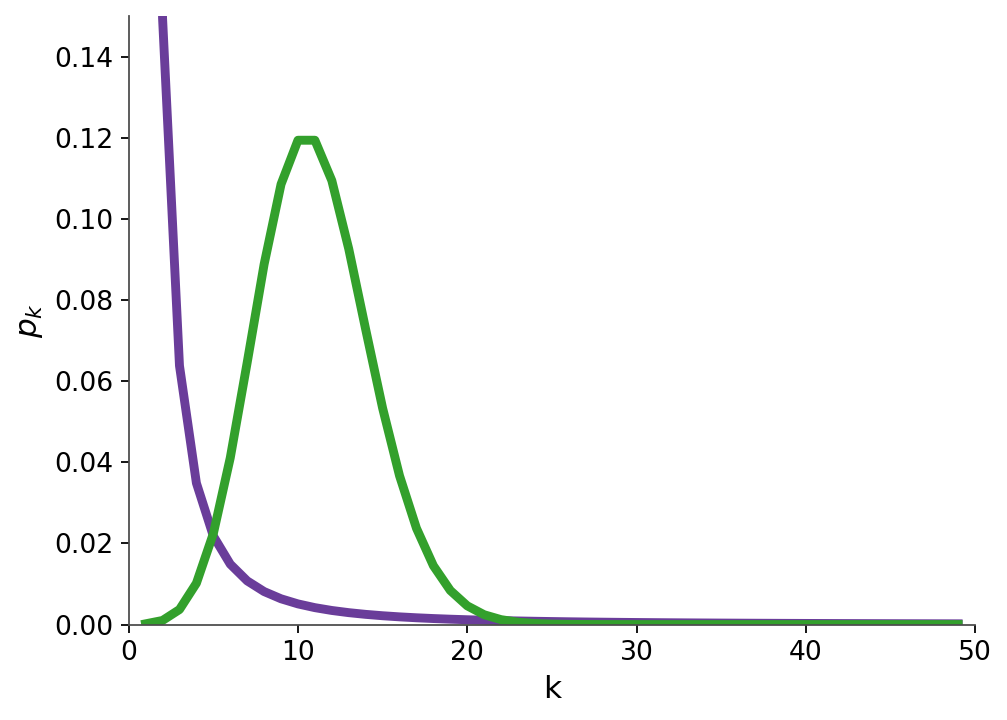

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy import special as sp

def discrete_power_pmf(k, gamma=2.1):
    # Discrete power-law (zeta) pmf on k=1,2,3,...
    return (k ** (-gamma)) / sp.zeta(gamma, 1)

ks = np.arange(1, 50, dtype=float)
poisson_pks = poisson.pmf(ks, mu=11)
power_pks = discrete_power_pmf(ks, gamma=2.1)

plt.figure(figsize=(6.4, 4.6), dpi=160)

# Curves (colors chosen to match the figure)
plt.plot(ks, power_pks, linewidth=4, color="#6a3d9a")   # purple
plt.plot(ks, poisson_pks, linewidth=4, color="#33a02c") # green

# Axes to match panel (a)
plt.xlim(0, 50)
plt.ylim(0, 0.15)
plt.xlabel("k")
plt.ylabel(r"$p_k$")


plt.tight_layout()
plt.show()
